Практика 1: Исследование атак на модели ИИ. Fast Gradient Sign Method (FGSM)

Буланов Андрей Алексеевич ББМО-01-23

Цель задания: Познакомиться с одной из популярных атак на системы машинного обучения — атакой Fast Gradient Sign Method (FGSM). Задача — научиться использовать FGSM для создания противоречивых (adversarial) примеров, которые могут ввести обученную модель в заблуждение

Задачи:

1. Загрузить ранее обученную модель на датасете MNIST.
2. Изучить теоретические основы FGSM.
3. Реализовать атаку FGSM и сгенерировать противоречивые примеры.
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных данных.

In [1]:
# Импорт всех необходимых библеотек
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Скомпилируем модель, чтобы избежать предупреждения
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images.reshape(-1, 28, 28, 1), test_labels)
print(f'Точность на чистых изображениях: {test_acc:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.9723 - loss: 0.0923
Точность на чистых изображениях: 0.9759


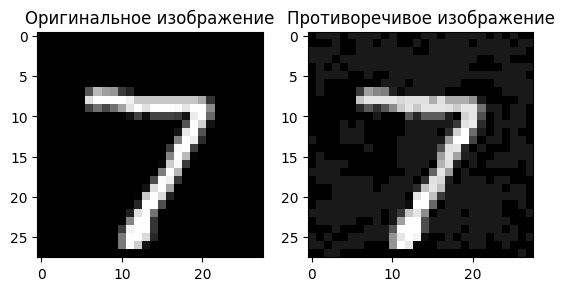

In [4]:
# Функция для реализации FGSM атаки
def fgsm_attack(image, epsilon, gradient):
    # Применение знака градиента к изображению
    perturbed_image = image + epsilon * np.sign(gradient)
    # Обрезка значений, чтобы они оставались в пределах [0,1]
    perturbed_image = np.clip(perturbed_image, 0, 1)
    return perturbed_image

# Вычисление градиента
def generate_adversarial_example(model, image, label, epsilon):
    # Приведение изображения к нужному формату
    image = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)))
    label = tf.convert_to_tensor(label)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        # Применение функции потерь
        loss = tf.keras.losses.sparse_categorical_crossentropy(label[None], prediction)

    # Получение градиента по отношению к входному изображению
    gradient = tape.gradient(loss, image)
    # Применение FGSM
    adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())
    return adversarial_image

# Пример использования
epsilon = 0.1  # Величина шума
adversarial_example = generate_adversarial_example(model, test_images[0], test_labels[0], epsilon)

# Вывод результатов
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(test_images[0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение")
plt.imshow(adversarial_example.reshape(28, 28), cmap="gray")
plt.show()

In [5]:
# Генерация противоречивых примеров для всего набора данных
def generate_adversarial_dataset(model, images, labels, epsilon):
    adversarial_images = []
    for i in range(len(images)):
        # Генерация противоречивого изображения
        adv_image = generate_adversarial_example(model, images[i], labels[i], epsilon)
        adversarial_images.append(adv_image)

    return np.array(adversarial_images)

# Генерация противоречивых примеров
adversarial_images = generate_adversarial_dataset(model, test_images, test_labels, epsilon)

# Оценка модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images.reshape(-1, 28, 28, 1), test_labels)
print(f'Точность на противоречивых примерах: {adversarial_acc:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.0918 - loss: 6.9379
Точность на противоречивых примерах: 0.1233


In [6]:
print(f'Точность на чистых изображениях: {test_acc:.4f}')
print(f'Точность на противоречивых примерах: {adversarial_acc:.4f}')

Точность на чистых изображениях: 0.9759
Точность на противоречивых примерах: 0.1233
